In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Batching

> This feature is still in Beta and will likly evolve based on user feedback.

An advanced feature of flow diagrams is that they support async batching of operations.
These means that if we want to process a list of tasks asynchronously, we dont have to write a node that processes the list.

Instead, we write a node that processes a single item, and instruct stringdale to run our function on every item of a list in our input seperately.

In [ ]:
import asyncio
from stringdale import Define,V,E,Condition

In [ ]:
async def async_add(a,b,c):
    await asyncio.sleep(0.1)
    return a+b+c

async def async_add100(a):
    await asyncio.sleep(0.1)
    return a+100


class Range:
    def __init__(self,length,step=1):
        self.length = length
        self.step = step
    def __call__(self,initial_value=0):
        return list(range(initial_value,initial_value+self.length*self.step,self.step))
    def __str__(self):
        return f'Range({self.length},{self.step})'


## For_Each

We can define a diagram as follows:

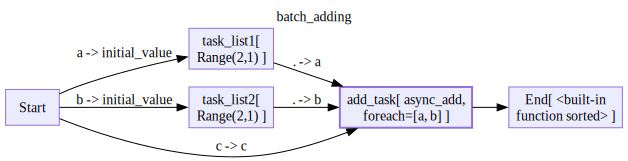

In [ ]:
with Define('batch_adding') as D:
    V('task_list1',Range(2),inputs=['Start(initial_value=a)'])
    V('task_list2',Range(2),inputs=['Start(initial_value=b)'])
    V('add_task',async_add,
        inputs=['task_list1(a=.)','task_list2(b=.)','Start(c=c)'],
        # for each is a list of input ports to map the function on
        # in this case, we have input ports a,b and c
        # a and b are for each, so we will run async_add for each combination of item from a and item from b
        # c is not in for_each, so it will be the same for each run
        for_each=['a','b'])
    
    # since async_add is now a foreach node, it will be called multiple times and the results will be collected into a list
    # before being fed into a regular node
    # we can sort the list to make sure that the results are deterministic
    V('End',sorted,inputs=['add_task'])
D.draw()

In [ ]:
d=D()
for trace in d.run({'a':1000,'b':100,'c':10}):
    trace.pprint()


Node Start:
{ 'input': {'a': 1000, 'b': 100, 'c': 10},
  'output': {'a': 1000, 'b': 100, 'c': 10}}
Node task_list2:
{'input': {'initial_value': 100}, 'output': [100, 101]}
Node task_list1:
{'input': {'initial_value': 1000}, 'output': [1000, 1001]}
Node add_task[0]:
{'input': {'a': 1000, 'b': 100, 'c': 10}, 'output': 1110}
Node add_task[1]:
{'input': {'a': 1000, 'b': 101, 'c': 10}, 'output': 1111}
Node add_task[2]:
{'input': {'a': 1001, 'b': 100, 'c': 10}, 'output': 1111}
Node add_task[3]:
{'input': {'a': 1001, 'b': 101, 'c': 10}, 'output': 1112}
Node End:
{'input': {0: [1110, 1111, 1111, 1112]}, 'output': [1110, 1111, 1111, 1112]}


## Flat

Working with lists and lists of lists can get out of hand quickly. We also supply a `flat` that will flatten out nested lists

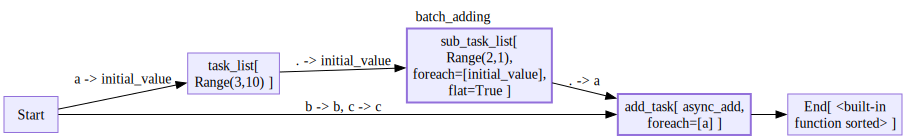

In [ ]:
with Define('batch_adding') as D:
    V('task_list',Range(3,step=10),inputs=['Start(initial_value=a)'])
    
    V('sub_task_list',Range(2),
        inputs=['task_list(initial_value=.)'],
        for_each=['initial_value'],
        # Since Range returns lists, and it is a foreach node, the output of this node will be a list of lists
        # flat=True will flatten this list of lists into a single list
        flat=True)
    
    V('add_task',async_add,
        inputs=['sub_task_list(a=.)','Start(b=b,c=c)'],
        for_each=['a'],)
    
    # since async_add is now a foreach node, it will be called multiple times and the results will be collected into a list
    V('End',sorted,inputs=['add_task'])
D.draw()

In [ ]:
d= D()
for trace in d.run({'a':1000,'b':0,'c':0}):
    trace.pprint()


Node Start:
{'input': {'a': 1000, 'b': 0, 'c': 0}, 'output': {'a': 1000, 'b': 0, 'c': 0}}
Node task_list:
{'input': {'initial_value': 1000}, 'output': [1000, 1010, 1020]}
Node sub_task_list[2]:
{'input': {'initial_value': 1020}, 'output': [1020, 1021]}
Node sub_task_list[0]:
{'input': {'initial_value': 1000}, 'output': [1000, 1001]}
Node sub_task_list[1]:
{'input': {'initial_value': 1010}, 'output': [1010, 1011]}
Node add_task[1]:
{'input': {'a': 1021, 'b': 0, 'c': 0}, 'output': 1021}
Node add_task[3]:
{'input': {'a': 1001, 'b': 0, 'c': 0}, 'output': 1001}
Node add_task[0]:
{'input': {'a': 1020, 'b': 0, 'c': 0}, 'output': 1020}
Node add_task[2]:
{'input': {'a': 1000, 'b': 0, 'c': 0}, 'output': 1000}
Node add_task[4]:
{'input': {'a': 1010, 'b': 0, 'c': 0}, 'output': 1010}
Node add_task[5]:
{'input': {'a': 1011, 'b': 0, 'c': 0}, 'output': 1011}
Node End:
{ 'input': {0: [1021, 1001, 1020, 1000, 1010, 1011]},
  'output': [1000, 1001, 1010, 1011, 1020, 1021]}


## Batching beyond stringdale

At the moment stringdale's batching is far from comprehensive.
But this shouldn't limit you. Not all of your logic needs to be in stringdale.

Let us look at the following example. Lets say you are building a batch server and you would like to:
* Process items every time you have 2 pending requests.
* Send items to storage in batches of 3

Here are some mocks for our ingress and egress logic

In [ ]:
class InputQueue:
    def __init__(self,items):
        self.items = items
    async def chunk(self):
        # imagine that you are listening to a queue
        # yield each 2 items as a list, pop them from the queue
        while len(self.items) >= 2:
            await asyncio.sleep(0.1)
            yield [self.items.pop(0),self.items.pop(0)]
        if len(self.items) == 1:
            await asyncio.sleep(0.1)
            yield [self.items.pop(0)]

class OutputQueue:
    def __init__(self):
        self.items = []
        self.upload_tasks = []  # Store pending upload tasks
        self.processed_batches = []
        
    async def add(self, add_batch):
        self.items.extend(add_batch)
        
        if len(self.items) >= 3:
            to_upload = [self.items.pop(0), self.items.pop(0), self.items.pop(0)]
            # Create upload task but don't await it
            upload_task = asyncio.create_task(self.upload(to_upload))
            self.upload_tasks.append(upload_task)
        return add_batch
        
    async def upload(self, add_batch):
        # implement your upload logic here
        await asyncio.sleep(0.1)
        self.processed_batches.append(add_batch)
        return True
        
    async def wait_for_uploads(self):
        # Optional: Method to wait for all pending uploads to complete
        if self.upload_tasks:
            await asyncio.gather(*self.upload_tasks)
            self.upload_tasks.clear()

Given a diagram that iterates over a single item.

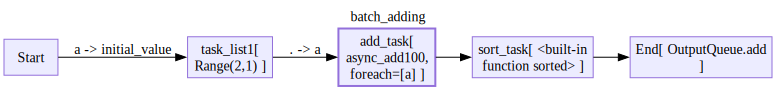

In [ ]:
input_queue = InputQueue([1,2,3,4,5,6,7,8,9,10])
output_queue = OutputQueue()

with Define('batch_adding') as D:
    V('task_list1',Range(2),inputs=['Start(initial_value=a)'])
    V('add_task',async_add100,
        inputs=['task_list1(a=.)'],
        for_each=['a'])

    V('sort_task',sorted,inputs=['add_task'])
    
    V('End',output_queue.add,inputs=['sort_task'])
D.draw()

We can run it like so:

In [ ]:
d= D()
d.state.b = 0
d.state.c = 0
async for batch in input_queue.chunk():
    for item in batch:
        async for trace in d.arun({'a':item}):
            pass # send traces to log server

await output_queue.wait_for_uploads()
output_queue.processed_batches,output_queue.items

([[103, 104, 104],
  [105, 105, 106],
  [106, 107, 107],
  [108, 108, 109],
  [109, 110, 110]],
 [111])

## Example - ingest documents for RAG

In this example, we will build 2 coupled diagrams.
1. A rag that summarizes the query before looking it up in the vector DB
2. A diagram that chunks documents, summarizes them and uploads them to our vector DB

In [ ]:
from stringdale.chat import Chat
from stringdale.db import ChromaClient
from pprint import pprint

In [ ]:
client = ChromaClient()

### Upload Docs

Lets say we have a list of documents we want to base our RAG on.
The first step is to split them into chunks. Here is a basic example.

In [ ]:
sample_doc = {'text':"""
The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.

The arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. During winter, its thick white fur provides both insulation and camouflage in the snowy landscape, while in summer its coat turns brownish-gray to blend with the tundra. These resourceful predators can survive temperatures as low as -50°C (-58°F) and will travel vast distances across the Arctic ice in search of food, often following polar bears to scavenge their leftovers.

The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan.
""",
'id':'animal_book'
}

In [ ]:
def splitter(doc):
    doc_id = doc['id']
    text = doc['text']
    return [{'text':chunk.strip(),'id':f'{doc_id}_{i}'} for i,chunk in enumerate(text.split('\n\n'))]

chunks = splitter(sample_doc)
chunks



[{'text': 'The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.',
  'id': 'animal_book_0'},
 {'text': 'The arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. During winter, its thick white fur provides both insulation and camouflage in the snowy landscape, while in summer its coat turns brownish-gray to blend with the tundra. These resourceful predators can survive temperatures as low as -50°C (-58°F) and will travel vast distances across the Arctic ice in search of food, often following polar bears to scavenge their leftovers.',
  'id': 'animal_book_1'},
 {'text': "The octopu

Now we would like to summarize each chunk.

In [ ]:
summarizer = Chat(model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that summarizes chunks of text.
        Here are some examples of how to summarize text:
        Text:
        Dogs are loyal companions that come in many breeds. They are known for their intelligence, 
        trainability and ability to form strong bonds with humans. Dogs have been domesticated 
        for thousands of years and serve many roles including pets, working animals, and service animals.
        They communicate through barking, body language and facial expressions. Most dogs are social 
        animals that thrive on interaction with their human families.
        Summary:
        Description of dogs as pets.
        '''},
        {'role':'user','content':'{{text}}'}
    ])

res = await summarizer(text=chunks[0]['text'])
res


{'role': 'assistant',
 'content': 'Description of elephants as intelligent and social animals with strong family bonds.',
 'meta': {'input_tokens': 292, 'output_tokens': 20}}

After running the summarizer in its own node, we would get data that looks something like this.

In [ ]:
unstructured_summary = {
   'doc':{
      'text': "The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan.",
      'id': 'animal_book_2'
   },
   'summary': 'Description of elephants as intelligent and social animals.',
}

We would like to end up with chunks of the following shape:

In [ ]:
chunk_example = {
    'text': 'Here we put a summary of the text so we can index the chunk based on the summary',
    'id': 'doc_id',
    'metadata':{
        'full_text': '''
            Here we put the original text, so we can access it when we retrieve the chunk
            It is the full text that we would inject into the prompt
        '''
    }
}

Many API's require building nested objects from existing objects. To make this simpler, we made a utility that helps us build functions that take a bunch of input objects, and structure them into a nested object.

In [ ]:
from stringdale import StructureJson

In [ ]:
StructureJson('text=summary','id=doc.id','metadata.full_text=doc.text')(**unstructured_summary)

{'text': 'Description of elephants as intelligent and social animals.',
 'id': 'animal_book_2',
 'metadata': {'full_text': "The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan."}}

Lets put it all together into a summarize chunk diagram.

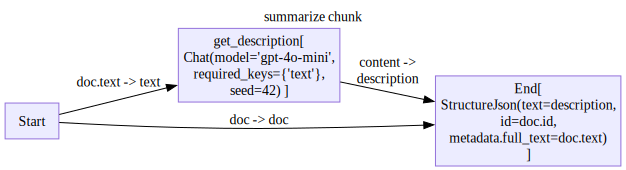

In [ ]:
with Define('summarize chunk',type='flow') as SummarizeChunk:
    V('get_description',summarizer,inputs=['Start(text=doc.text)'])
    V('End',StructureJson('text=description','id=doc.id','metadata.full_text=doc.text'),
        inputs=['Start(doc=doc)',
        'get_description(description=content)'
        ])
SummarizeChunk.draw()

Now we will build our RAG uploader diagram. For each text we will:

* split it into chunks
* summarize each chunk
* push them all to the db

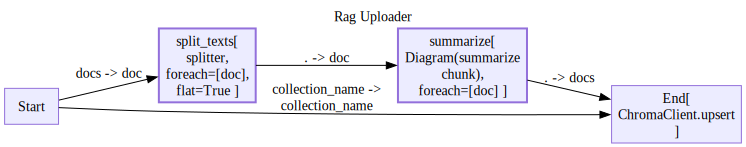

In [ ]:
with Define('Rag Uploader',type='flow') as RagUpload:
    V('split_texts',splitter,inputs=['Start(doc=docs)'],for_each=['doc'],flat=True)
    V('summarize',SummarizeChunk,
        inputs=['split_texts(doc=.)'],
        for_each=['doc'])
    V('End',client.upsert,inputs=['summarize(docs)','Start(collection_name=collection_name)'])

RagUpload.draw()


In [ ]:
client.add_collection("animal_book",exists_ok=True)
d = RagUpload()
for trace in d.run({'docs':[sample_doc],'collection_name':'animal_book'}):
    # trace.pprint()
    pass

d.output


[{'text': 'Description of elephants as intelligent and social animals with strong family bonds.',
  'id': 'animal_book_0',
  'metadata': {'full_text': 'The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.'}},
 {'text': 'Description of octopuses as intelligent invertebrates with unique abilities.',
  'id': 'animal_book_2',
  'metadata': {'full_text': "The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both c

### RAG

Now we can query our db, but we have to make sure that we convey our query into a chunk summary, so that we get relevant chunks from our document.

In [ ]:
guess_summary = topic_summarizer = Chat(model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that predicts what kind of summaries will be helpful for a given query.
        Here are some examples:
        query:
        I have an elephant and a dog. What is the most important thing about them?
        Summaries:
        Descriptions of elephants.
        Descriptions of dogs.
        query:
        What is the most important thing about elephants?
        Summaries:
        Descriptions of elephants.
        query:
        What is the most important thing about dogs?
        Summaries:
        Description of dogs as pets.
        '''},
        {'role':'user','content':'query:{{query}}'},
        {'role':'assistant','content':'summaries:'}

    ])

res = await guess_summary(query="I need help with my lion choco")
pprint(res)

{'content': 'Descriptions of lion chocolates, their ingredients, and tips for '
            'enjoying them.',
 'meta': {'input_tokens': 220, 'output_tokens': 21},
 'role': 'assistant'}


Now we can build our RAG as usual. To make it more interesting, we will add some few-shot example on how we would like the chat to answer our queries.

In [ ]:
full_text_rag_prompt = [
            {'role':'system','content':'''
            You are a helpful assistant that answers questions about animals.

            Here are some examples of how to answer questions about animals:
            {% for example in examples %}
            Question: {{example['question']}}
            Answer: {{example['answer']}}
            {% endfor %}

            I found the following documents that may be relevant to the user's question:
            {% for doc in docs %}
            {{doc['metadata']['full_text']}}
            {% endfor %}
            '''},
            {'role':'user','content':'{{input}}'},
            ]

style_examples = [
    {
        'question': "What are the key traits of Pandas?",
        'answer': """Here are the key traits of Pandas:

            • Pandas are a type of bear
            • They are native to South America
            • They are known for their black and white fur
            • They are known for their love of bamboo"""
    },
    {
        'question': "What are the key traits of Lions?",
        'answer': """Here are the key traits of Lions:
        
            • Lions are a type of bear
            • They are native to Africa
            • They are known for their mane of hair"""
    }
]

# note that we bake the example in to the prompt
# there fore we do not need to feed them to the node inside the diagram
few_shot_rag_chat = Chat(model='gpt-4o-mini',
    messages=full_text_rag_prompt,
    examples=style_examples 
    )
few_shot_rag_chat

Chat(model='gpt-4o-mini', required_keys={'input', 'docs'}, seed=42)

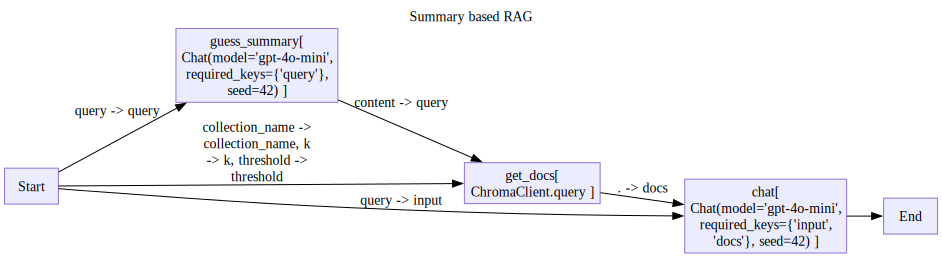

In [ ]:
with Define('Summary based RAG',type='flow') as SummaryRAG:
    V('guess_summary',guess_summary,
        inputs=['Start(query=query)'],
    )
    V('get_docs',client.query,
        inputs=['guess_summary(query=content)','Start(collection_name=collection_name,k=k,threshold=threshold)'],
    )
    V('chat',few_shot_rag_chat,
        inputs=['get_docs(docs)','Start(input=query)'],
        outputs=['End']
    )
SummaryRAG.draw()

In [ ]:
d=SummaryRAG()
for trace in d.run({'query':'I need help with my elephant choco','collection_name':'animal_book','k':2,'threshold':1}):
    trace.pprint(skip_passthrough=True)
print(d.output['content'])

Node guess_summary:
{ 'input': {'query': 'I need help with my elephant choco'},
  'output': { 'content': 'Descriptions of elephants and care tips for pet '
                         'elephants.',
              'meta': {'input_tokens': 220, 'output_tokens': 17},
              'role': 'assistant'}}
Node get_docs:
{ 'input': { 'collection_name': 'animal_book',
             'k': 2,
             'query': 'Descriptions of elephants and care tips for pet '
                      'elephants.',
             'threshold': 1},
  'output': [ { 'distance': 0.7586846351623535,
                'id': 'animal_book_0',
                'metadata': { 'full_text': 'The elephant is one of the most '
                                           'remarkable creatures on Earth. '
                                           'Known for their intelligence and '
                                           'complex social structures, '
                                           'elephants form deep family bonds '
        